For this project, i will be building and training a basic character-level Recurrent Neural Network (RNN) to classify surnames from 18 languages of origin, and predict which language a name is from based on the spelling. 

In [1]:
from io import open
import glob
import os
import unicodedata
import string

The dataset being used contains 18 text files named after their respective language, each file contains a bunch of names, one name per line. The text is formated in unicode and will first need to be converted to ascii before we can do anything else. We’ll end up with a dictionary of lists of names per language, {language: [names ...]}.

In [2]:
def findFiles(path): return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


['/Users/zaccardwell/Python/Datasets/language/names/Czech.txt', '/Users/zaccardwell/Python/Datasets/language/names/German.txt', '/Users/zaccardwell/Python/Datasets/language/names/Arabic.txt', '/Users/zaccardwell/Python/Datasets/language/names/Japanese.txt', '/Users/zaccardwell/Python/Datasets/language/names/Chinese.txt', '/Users/zaccardwell/Python/Datasets/language/names/Vietnamese.txt', '/Users/zaccardwell/Python/Datasets/language/names/Russian.txt', '/Users/zaccardwell/Python/Datasets/language/names/French.txt', '/Users/zaccardwell/Python/Datasets/language/names/Irish.txt', '/Users/zaccardwell/Python/Datasets/language/names/English.txt', '/Users/zaccardwell/Python/Datasets/language/names/Spanish.txt', '/Users/zaccardwell/Python/Datasets/language/names/Greek.txt', '/Users/zaccardwell/Python/Datasets/language/names/Italian.txt', '/Users/zaccardwell/Python/Datasets/language/names/Portuguese.txt', '/Users/zaccardwell/Python/Datasets/language/names/Scottish.txt', '/Users/zaccardwell/Pytho

In [3]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/Users/zaccardwell/Python/Datasets/language/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning names into vectors using character level onehot encoding ie: b = [0100...] with the final word vctor being of length <line_length x 1 x n_letters> That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In this project, i will be using pytorchs defult RNN class wth a hidden layer of 128 that will feed into a single linear layer and finaly a softmax layer. I will be creating three diffrent models each with diffrent parameters in order to compare their indivual effect on the accuracy. The first model will be a traditional RNN with a single layer, the second model will contain 3 layers, and the third model will be bidirectional. 

In [5]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.RNN(input_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        output, hn = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)
    
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
class RNN1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN1, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers=3)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        output, hn = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(3, 1, self.hidden_size)
    
    
rnn1 = RNN1(n_letters, n_hidden, n_categories)

In [23]:
class RNN2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.RNN(input_size, hidden_size, bidirectional = True)
        self.fc = torch.nn.Linear(hidden_size*2, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=2)
        
    def forward(self, input, hidden):
        output, hn = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output

    def initHidden(self):
        return torch.zeros(2, 1, self.hidden_size)
    
    
n_hidden = 128
rnn2 = RNN2(n_letters, n_hidden, n_categories)

Before training, we need a way to interpret the output of the network, a likelihood of each category, to get the index of the greatest value using pytorch topk function

In [7]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

These functions will randomly get a training example (a name and its language)

In [8]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Oppenheimer
category = Russian / line = Guzik
category = Italian / line = Luzzatto
category = French / line = Fay
category = Spanish / line = Oleastro
category = Irish / line = Dalach
category = Japanese / line = Numata
category = Polish / line = Sniegowski
category = Spanish / line = Mata
category = Irish / line = Collins


For training i will be usind negative log likelihood loss and Stochastic Gradient Descent as the optimizer with a learning rate of .005 and 100 000 epochs. After traing is complete, it will plot the historical loss from all_losses showing the network learning. To see how well each network performs on different categories, i will also be creating a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). 

In [9]:
def train(category_tensor, line_tensor, model):
    criterion = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    hidden = model.initHidden()
    model.zero_grad()

    output = model(line_tensor, hidden)

    loss = criterion(output[-1], category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [13]:
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch.nn as nn

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def trainer(model):
    n_iters = 100000
    print_every = 5000
    plot_every = 1000

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    start = time.time()

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(category_tensor, line_tensor, model)
        current_loss += loss

        # Print ``iter`` number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            
    plt.figure()
    plt.plot(all_losses)

In [11]:
def conf(model):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 10000

    # Just return an output given a line
    def evaluate(line_tensor):
        hidden = model.initHidden()

        output = model(line_tensor, hidden)

        return output[-1]

    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = evaluate(line_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = all_categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + all_categories, rotation=90)
    ax.set_yticklabels([''] + all_categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

Evaluation for the single layer RNN

5000 5% (0m 3s) 1.6070 Ko / Chinese ✗ (Korean)
10000 10% (0m 7s) 1.6743 Kerwer / Vietnamese ✗ (German)
15000 15% (0m 11s) 1.2356 Kim / Korean ✓
20000 20% (0m 15s) 2.1117 Macfarland / Korean ✗ (Irish)
25000 25% (0m 18s) 3.6942 Latham / Korean ✗ (English)
30000 30% (0m 22s) 0.1824 Mikolajczak / Korean ✗ (Polish)
35000 35% (0m 26s) 0.8395 Ding / Korean ✗ (Chinese)
40000 40% (0m 30s) 1.6825 Caiazzo / Russian ✗ (Italian)
45000 45% (0m 33s) 1.4697 Zuraw / English ✗ (Polish)
50000 50% (0m 37s) 2.3070 Close / Russian ✗ (Greek)
55000 55% (0m 41s) 0.0263 Wronski / Korean ✗ (Polish)
60000 60% (0m 44s) 0.1673 Millar / Korean ✗ (Scottish)
65000 65% (0m 48s) 2.7301 Barros / Korean ✗ (Spanish)
70000 70% (0m 52s) 0.0104 Jevlakov / German ✗ (Russian)
75000 75% (0m 56s) 0.0885 Meeuwissen / Korean ✗ (Dutch)
80000 80% (1m 0s) 1.2511 Castell / Dutch ✗ (Spanish)
85000 85% (1m 3s) 3.6042 Jones / German ✗ (Scottish)
90000 90% (1m 7s) 0.2483 Sneijder / Dutch ✓
95000 95% (1m 11s) 1.2623 Meeuweszen / Korean ✗ (D

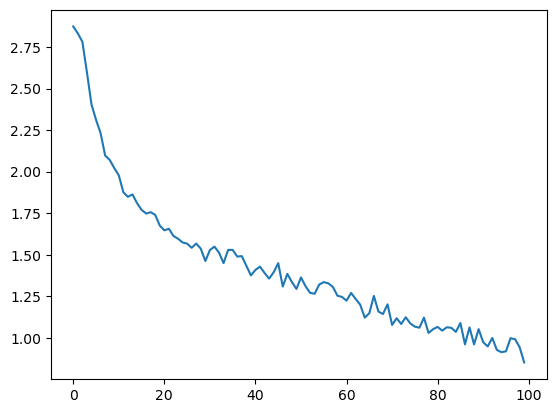

In [14]:
trainer(rnn)

/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


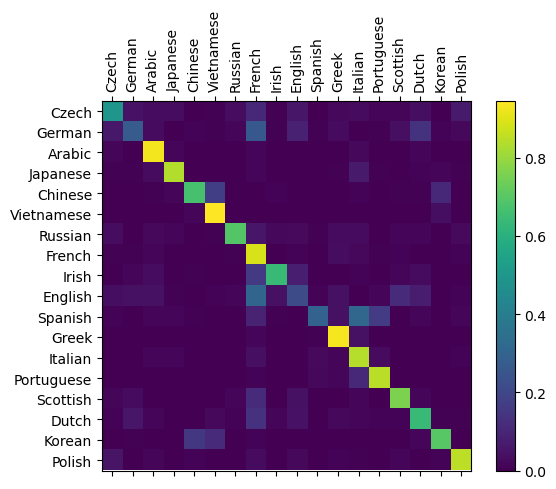

In [15]:
conf(rnn)

Evaluation for the RNN with three layers

5000 5% (0m 9s) 1.3648 Hiu / Vietnamese ✗ (Chinese)
10000 10% (0m 18s) 1.9104 Srpcikova / Vietnamese ✗ (Czech)
15000 15% (0m 27s) 0.6616 Chu / Vietnamese ✓
20000 20% (0m 36s) 3.9862 Bartosz / Vietnamese ✗ (Polish)
25000 25% (0m 45s) 0.3571 Paitakes / Scottish ✗ (Greek)
30000 30% (0m 54s) 1.3374 Kusatsu / Scottish ✗ (Japanese)
35000 35% (1m 3s) 0.4811 An / Korean ✗ (Vietnamese)
40000 40% (1m 13s) 2.1736 Oorschot / Korean ✗ (Dutch)
45000 45% (1m 22s) 0.1233 Than / Vietnamese ✓
50000 50% (1m 31s) 1.1787 Larenz / Korean ✗ (German)
55000 55% (1m 40s) 0.0336 Naifeh / Korean ✗ (Arabic)
60000 60% (1m 49s) 1.1187 Sokolofsky / Korean ✗ (Polish)
65000 65% (1m 58s) 1.9930 Eikhenbaum / Korean ✗ (Russian)
70000 70% (2m 8s) 0.2825 Shan / Polish ✗ (Chinese)
75000 75% (2m 17s) 0.3928 Lokay / Korean ✗ (Czech)
80000 80% (2m 26s) 0.0556 Scarsi / Polish ✗ (Italian)
85000 85% (2m 35s) 0.7767 Loh / Chinese ✓
90000 90% (2m 45s) 0.0107 Pham / Scottish ✗ (Vietnamese)
95000 95% (2m 54s) 0.0173 Cervenka / Dutch ✗

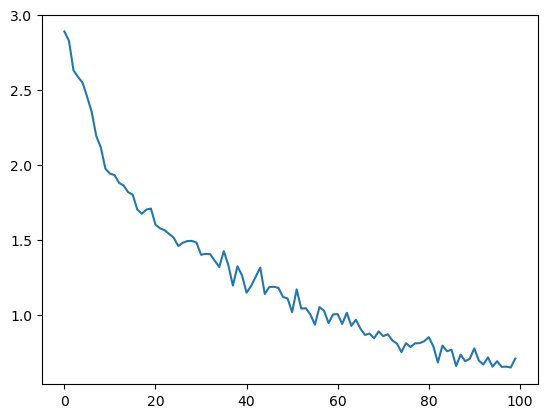

In [16]:
trainer(rnn1)

/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


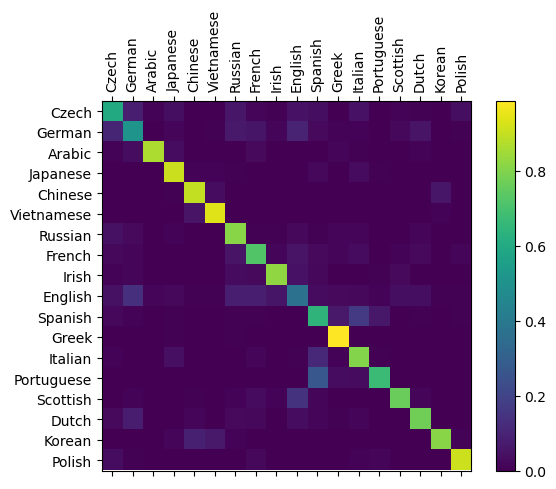

In [17]:
conf(rnn1)

Evaluation for the bidirectional RNN 

5000 5% (0m 6s) 1.9444 Srour / Korean ✗ (Arabic)
10000 10% (0m 12s) 2.3827 Vejvoda / Korean ✗ (Czech)
15000 15% (0m 18s) 2.1136 Usik / Korean ✗ (Russian)
20000 20% (0m 25s) 2.1280 Hirsch / Korean ✗ (German)
25000 25% (0m 31s) 1.3016 Mendes / Scottish ✗ (Portuguese)
30000 30% (0m 37s) 0.3105 Duong / Vietnamese ✓
35000 35% (0m 44s) 1.3304 Fearghal / Scottish ✗ (Irish)
40000 40% (0m 50s) 3.3113 Haigh / Korean ✗ (English)
45000 45% (0m 56s) 0.2837 Yokoyama / Korean ✗ (Japanese)
50000 50% (1m 3s) 1.9544 Hierro / Korean ✗ (Spanish)
55000 55% (1m 9s) 0.1138 Amari / Korean ✗ (Arabic)
60000 60% (1m 15s) 2.9764 De la fuente / Russian ✗ (Spanish)
65000 65% (1m 22s) 0.4744 Login / Korean ✗ (Irish)
70000 70% (1m 28s) 0.1499 Yeon / Korean ✓
75000 75% (1m 34s) 0.2422 Mclaughlin / Dutch ✗ (Scottish)
80000 80% (1m 41s) 2.7846 Odonoghue / Korean ✗ (English)
85000 85% (1m 47s) 0.1022 Tieu / Vietnamese ✓
90000 90% (1m 53s) 0.0791 Molev / Dutch ✗ (Russian)
95000 95% (2m 0s) 1.0012 Weber / English ✗ (German

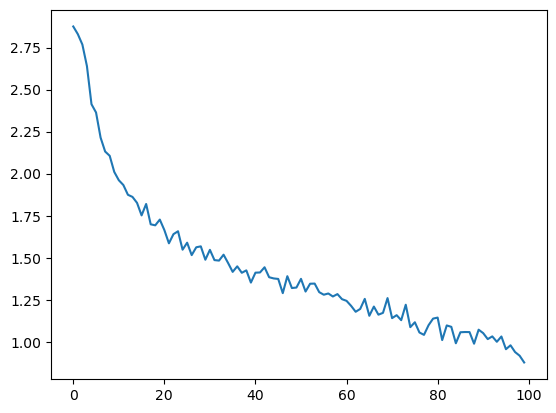

In [24]:
trainer(rnn2)

/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/mx/9rzr40d156z40qxyrcjrxd940000gn/T/ipykernel_12914/1744933887.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


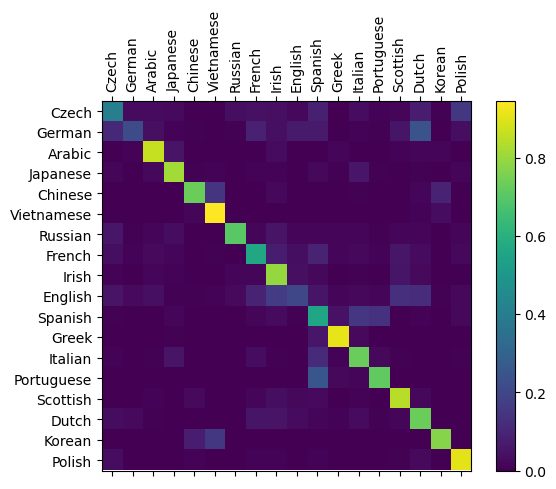

In [25]:
conf(rnn2)